In [1]:
import pandas as pd #used for data analysis
import numpy as np 

import requests# library to handle requests
from pandas.io.json  import json_normalize # tranform JSON file into a pandas dataframe

!pip install geopy
from geopy.geocoders import Nominatim #to find latitude and longitude

!pip install pgeocode 
import pgeocode #find latitude and longitude

!pip install folium
import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

print('All neccessary Libraries are imported.')

     |████████████████████████████████| 93 kB 3.7 MB/s  eta 0:00:01
All neccessary Libraries are imported.


### Extract and explore data sets

In [2]:
#Extract the list of neighborhood in San Francisco
bayareacode = pd.read_csv("https://data.sfgov.org/api/views/f9wk-m4qb/rows.csv?accessType=DOWNLOAD")
bayareacode

PO_NAME                                           the_geom    ZIP  \
0         NAPA  MULTIPOLYGON (((-122.10329200180091 38.5132829...  94558   
1    FAIRFIELD  MULTIPOLYGON (((-121.947475002335 38.301511000...  94533   
2        DIXON  MULTIPOLYGON (((-121.65335500334429 38.3133870...  95620   
3       SONOMA  MULTIPOLYGON (((-122.406843003057 38.155681999...  95476   
4         NAPA  MULTIPOLYGON (((-122.29368500225117 38.1552379...  94559   
..         ...                                                ...    ...   
182  LOS ALTOS  MULTIPOLYGON (((-122.09598200263689 37.3860539...  94022   
183  SUNNYVALE  MULTIPOLYGON (((-121.98688800346149 37.3886580...  94085   
184  SUNNYVALE  MULTIPOLYGON (((-122.05999500035823 37.3752980...  94086   
185  LOS ALTOS  MULTIPOLYGON (((-122.09598200263689 37.3860539...  94024   
186  SUNNYVALE  MULTIPOLYGON (((-122.06240400062882 37.3592939...  94087   

    STATE        Area__       Length__  
0      CA  1.231326e+10  995176.225313  
1      CA  9.917861e+08  200772.556587  
2      CA  7.236950e+09  441860.201400  
3      CA  3.001414e+09  311318.546326  
4      CA  1.194302e+09  359104.646602  
..    ...           ...            ...  
182    CA  4.211365e+08  137369.776481  
183    CA  9.054792e+07   47415.860456  
184    CA  1.289431e+08   65560.361543  
185    CA  2.966973e+08  136286.642980  
186    CA  1.843369e+08   74339.948036  

[187 rows x 6 columns]

In [3]:
#Remove the unwanted column
bayareacode.drop(columns=['the_geom','Area__','Length__'], inplace=True)
bayareacode

#df_sfozipcode = bayareacode[(bayareacode['PO_NAME'] == 'SAN FRANCISCO') | (bayareacode['PO_NAME']=='SOUTH SAN FRANCISCO')].reset_index(drop=True)
#df_sfozipcode = bayareacode.reset_index(drop=True)
#df_sfozipcode

PO_NAME    ZIP STATE
0         NAPA  94558    CA
1    FAIRFIELD  94533    CA
2        DIXON  95620    CA
3       SONOMA  95476    CA
4         NAPA  94559    CA
..         ...    ...   ...
182  LOS ALTOS  94022    CA
183  SUNNYVALE  94085    CA
184  SUNNYVALE  94086    CA
185  LOS ALTOS  94024    CA
186  SUNNYVALE  94087    CA

[187 rows x 3 columns]

In [4]:
#Extract the geo locations
us = pgeocode.Nominatim('US')
for index,row in bayareacode.iterrows():
    #print(row['ZIP'],us.query_postal_code(row['ZIP'])["latitude"],us.query_postal_code(row['ZIP'])["longitude"])
    bayareacode.at[index,'Latitude'] = us.query_postal_code(row['ZIP'])["latitude"]
    bayareacode.at[index,'Longitude'] = us.query_postal_code(row['ZIP'])["longitude"]
    
bayareacode

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pgeocode.py:173: UserWarning: Download from https://download.geonames.org/export/zip/US.zip failed with: HTTP Error 404: Not Found. Trying next URL in DOWNLOAD_URL list.
  UserWarning,


PO_NAME    ZIP STATE  Latitude  Longitude
0         NAPA  94558    CA   38.4549  -122.2564
1    FAIRFIELD  94533    CA   38.2671  -122.0357
2        DIXON  95620    CA   38.4403  -121.8088
3       SONOMA  95476    CA   38.2849  -122.4696
4         NAPA  94559    CA   38.2904  -122.2841
..         ...    ...   ...       ...        ...
182  LOS ALTOS  94022    CA   37.3814  -122.1258
183  SUNNYVALE  94085    CA   37.3886  -122.0177
184  SUNNYVALE  94086    CA   37.3764  -122.0238
185  LOS ALTOS  94024    CA   37.3547  -122.0862
186  SUNNYVALE  94087    CA   37.3502  -122.0349

[187 rows x 5 columns]

In [5]:
#Find the geo data for San Francisco
address = 'SAN FRANCISCO, CA'
geolocator = Nominatim(user_agent="ON_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of SAN FRANCISCO City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of SAN FRANCISCO City are 37.7790262, -122.4199061.


In [6]:
#create a map of SFO using latitude and longitude of SFO
map_sfo = folium.Map(location=[latitude,longitude],zoomlevel=5)

#add markers to map
for lat, lng, borough,area in zip(bayareacode['Latitude'], bayareacode['Longitude'], bayareacode['PO_NAME'],bayareacode['ZIP']):
    label = '{}, {}'.format(borough,area)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(map_sfo)
    
map_sfo

### Foursquare Data
##### Define Foursquare Credentials and Version

In [7]:
CLIENT_ID = 'O4BDYAKNHUHG33TOFTGDITACGPPHBC2BZHE5K41FOLTEUHJM' # your Foursquare ID
CLIENT_SECRET = 'PO042IY5ONTYEWODF3T0VYVN41WL2HQK3CDS31UQRHL4L4GS' # your Foursquare Secret
VERSION = '20201213' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: O4BDYAKNHUHG33TOFTGDITACGPPHBC2BZHE5K41FOLTEUHJM
CLIENT_SECRET:PO042IY5ONTYEWODF3T0VYVN41WL2HQK3CDS31UQRHL4L4GS


In [8]:
#Function to request the Foursquare and return the relevant venue data
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
#Extract the list of Indian resturants and other venues from Foursquare
radius = 3000 
limit = 100
bayarea_venues = getNearbyVenues(names=bayareacode['PO_NAME'],
                                   latitudes=bayareacode['Latitude'],
                                   longitudes=bayareacode['Longitude']
                                  )



In [10]:
print(bayarea_venues.shape)

(3429, 7)


In [11]:
bayarea_venues.head()

Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0          NAPA                 38.4549                -122.2564   
1          NAPA                 38.4549                -122.2564   
2     FAIRFIELD                 38.2671                -122.0357   
3     FAIRFIELD                 38.2671                -122.0357   
4     FAIRFIELD                 38.2671                -122.0357   

                              Venue  Venue Latitude  Venue Longitude  \
0               Kayman Construction       38.456102      -122.256846   
1                Wine Country Dance       38.457504      -122.260709   
2  Pho Saigon Vietnamese Restaurant       38.264946      -122.033115   
3                    Baskin-Robbins       38.268040      -122.034462   
4                             Hertz       38.264945      -122.034667   

          Venue Category  
0           Home Service  
1           Dance Studio  
2  Vietnamese Restaurant  
3         Ice Cream Shop  
4    Rental Car Location

In [12]:
bayarea_venues.groupby('Neighbourhood').count()

Neighbourhood Latitude  Neighbourhood Longitude  Venue  \
Neighbourhood                                                             
ALAMEDA                              31                       31     31   
ALBANY                               46                       46     46   
ALVISO                                5                        5      5   
AMERICAN CANYON                      21                       21     21   
ANTIOCH                              15                       15     15   
...                                 ...                      ...    ...   
TRAVIS AFB                           12                       12     12   
UNION CITY                            3                        3      3   
VALLEJO                              14                       14     14   
WALNUT CREEK                         20                       20     20   
WOODACRE                              2                        2      2   

                 Venue Latitude  Venue Longitude  Venue Category  
Neighbourhood                                                     
ALAMEDA                      31               31              31  
ALBANY                       46               46              46  
ALVISO                        5                5               5  
AMERICAN CANYON              21               21              21  
ANTIOCH                      15               15              15  
...                         ...              ...             ...  
TRAVIS AFB                   12               12              12  
UNION CITY                    3                3               3  
VALLEJO                      14               14              14  
WALNUT CREEK                 20               20              20  
WOODACRE                      2                2               2  

[87 rows x 6 columns]

In [13]:
print('There are {} uniques categories.'.format(len(bayarea_venues['Venue Category'].unique())))

bayarea_venues['Venue Category'].unique()

There are 358 uniques categories.


array(['Home Service', 'Dance Studio', 'Vietnamese Restaurant',
       'Ice Cream Shop', 'Rental Car Location', 'Korean Restaurant',
       'Bank', 'Automotive Shop', 'Convenience Store', 'Sandwich Place',
       'Fast Food Restaurant', 'Fried Chicken Joint', 'Pizza Place',
       'Grocery Store', 'Lawyer', 'Donut Shop', 'Japanese Restaurant',
       'Sushi Restaurant', 'Furniture / Home Store', 'Park',
       'Bed & Breakfast', 'Mexican Restaurant', 'Hotel', 'Boat or Ferry',
       'Food', 'Construction & Landscaping', 'Baseball Field',
       'Discount Store', 'Coffee Shop', 'Supplement Shop', 'Bakery',
       'Locksmith', 'Bowling Alley', 'Laundromat', 'Credit Union',
       'Pharmacy', 'Thai Restaurant', 'ATM', 'Thrift / Vintage Store',
       'Shipping Store', 'Video Store', 'Indian Restaurant', 'Brewery',
       'Massage Studio', 'Chinese Restaurant', 'Shopping Mall',
       'New American Restaurant', 'Dive Bar', 'American Restaurant',
       'Taco Place', 'Sporting Goods Shop', 

In [14]:
# one hot encoding
bayarea_onehot = pd.get_dummies(bayarea_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bayarea_onehot['Neighbourhood'] = bayarea_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [bayarea_onehot.columns[-1]] + list(bayarea_onehot.columns[:-1])
bayarea_onehot = bayarea_onehot[fixed_columns]

bayarea_onehot.head()

Neighbourhood  ATM  Acai House  Accessories Store  Acupuncturist  \
0          NAPA    0           0                  0              0   
1          NAPA    0           0                  0              0   
2     FAIRFIELD    0           0                  0              0   
3     FAIRFIELD    0           0                  0              0   
4     FAIRFIELD    0           0                  0              0   

   Adult Boutique  Afghan Restaurant  African Restaurant  Airport Service  \
0               0                  0                   0                0   
1               0                  0                   0                0   
2               0                  0                   0                0   
3               0                  0                   0                0   
4               0                  0                   0                0   

   American Restaurant  ...  Warehouse Store  Watch Shop  Weight Loss Center  \
0                    0  ...                0           0                   0   
1                    0  ...                0           0                   0   
2                    0  ...                0           0                   0   
3                    0  ...                0           0                   0   
4                    0  ...                0           0                   0   

   Whisky Bar  Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  \
0           0         0          0       0            0              0   
1           0         0          0       0            0              0   
2           0         0          0       0            0              0   
3           0         0          0       0            0              0   
4           0         0          0       0            0              0   

   Yoga Studio  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 359 columns]

In [15]:
bayarea_onehot.shape

(3429, 359)

In [16]:
bayarea_grouped = bayarea_onehot.groupby('Neighbourhood').mean().reset_index()
bayarea_grouped

Neighbourhood       ATM  Acai House  Accessories Store  Acupuncturist  \
0           ALAMEDA  0.032258         0.0                0.0            0.0   
1            ALBANY  0.000000         0.0                0.0            0.0   
2            ALVISO  0.000000         0.0                0.0            0.0   
3   AMERICAN CANYON  0.095238         0.0                0.0            0.0   
4           ANTIOCH  0.000000         0.0                0.0            0.0   
..              ...       ...         ...                ...            ...   
82       TRAVIS AFB  0.000000         0.0                0.0            0.0   
83       UNION CITY  0.000000         0.0                0.0            0.0   
84          VALLEJO  0.000000         0.0                0.0            0.0   
85     WALNUT CREEK  0.000000         0.0                0.0            0.0   
86         WOODACRE  0.000000         0.0                0.0            0.0   

    Adult Boutique  Afghan Restaurant  African Restaurant  Airport Service  \
0              0.0                0.0                 0.0              0.0   
1              0.0                0.0                 0.0              0.0   
2              0.0                0.0                 0.0              0.0   
3              0.0                0.0                 0.0              0.0   
4              0.0                0.0                 0.0              0.0   
..             ...                ...                 ...              ...   
82             0.0                0.0                 0.0              0.0   
83             0.0                0.0                 0.0              0.0   
84             0.0                0.0                 0.0              0.0   
85             0.0                0.0                 0.0              0.0   
86             0.0                0.0                 0.0              0.0   

    American Restaurant  ...  Warehouse Store  Watch Shop  Weight Loss Center  \
0              0.032258  ...              0.0         0.0                 0.0   
1              0.000000  ...              0.0         0.0                 0.0   
2              0.000000  ...              0.0         0.0                 0.0   
3              0.000000  ...              0.0         0.0                 0.0   
4              0.066667  ...              0.0         0.0                 0.0   
..                  ...  ...              ...         ...                 ...   
82             0.000000  ...              0.0         0.0                 0.0   
83             0.000000  ...              0.0         0.0                 0.0   
84             0.000000  ...              0.0         0.0                 0.0   
85             0.000000  ...              0.0         0.0                 0.0   
86             0.000000  ...              0.0         0.0                 0.0   

    Whisky Bar  Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  \
0          0.0       0.0        0.0     0.0          0.0            0.0   
1          0.0       0.0        0.0     0.0          0.0            0.0   
2          0.0       0.0        0.0     0.0          0.0            0.0   
3          0.0       0.0        0.0     0.0          0.0            0.0   
4          0.0       0.0        0.0     0.0          0.0            0.0   
..         ...       ...        ...     ...          ...            ...   
82         0.0       0.0        0.0     0.0          0.0            0.0   
83         0.0       0.0        0.0     0.0          0.0            0.0   
84         0.0       0.0        0.0     0.0          0.0            0.0   
85         0.0       0.0        0.0     0.0          0.0            0.0   
86         0.0       0.0        0.0     0.0          0.0            0.0   

    Yoga Studio  
0      0.000000  
1      0.000000  
2      0.000000  
3      0.000000  
4      0.000000  
..          ...  
82     0.000000  
83     0.000000  
84     0.071429  
85     0.000000  
86     0.000000  

[87 rows x 359 columns]

In [17]:
bayarea_grouped.shape

(87, 359)

In [18]:
#Filtered the Indian resturants only
df_indrest = bayarea_grouped.sort_values(by=['Indian Restaurant'],ascending=False)[['Neighbourhood','Indian Restaurant']]
df_indrest.reset_index(drop=True,inplace=True)
df_indrest.head(15)

Neighbourhood  Indian Restaurant
0         LAGUNITAS           0.500000
1            ALBANY           0.065217
2       SAN LORENZO           0.062500
3          BRISBANE           0.052632
4      WALNUT CREEK           0.050000
5   AMERICAN CANYON           0.047619
6         LIVERMORE           0.035714
7           FAIRFAX           0.034483
8          BERKELEY           0.033846
9          LARKSPUR           0.031250
10    MOUNTAIN VIEW           0.025974
11        SUNNYVALE           0.018868
12    SAN FRANCISCO           0.008158
13          OAKLAND           0.007092
14         RICHMOND           0.000000

url = 'https://api.foursquare.com/v2/venues/search?&categoryId=4bf58dd8d48988d10f941735&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            3000, 
            LIMIT)
print(url)
    

# K-Means Clustering 

In [19]:
#Modeling using K-means clustring
score =[]
indrest_grouped_cluster = df_indrest.drop('Neighbourhood',1)

#iteration to find the best value of K
for i in range(1,15):
    kmeans = KMeans(n_clusters=i, random_state=0,max_iter=500)
    kmeans.fit(indrest_grouped_cluster)
    score.append(kmeans.inertia_)

score

[0.26054156500127684,
 0.01882602127294346,
 0.002123330685646169,
 0.0005669500577454805,
 0.00033924423421825855,
 0.00016102450241664844,
 5.271442207946853e-05,
 2.7466083201007523e-05,
 1.7727346216524608e-05,
 8.898185483524465e-06,
 5.206077733051881e-06,
 2.371610612870462e-06,
 7.702963330337564e-07,
 4.052656389617888e-07]

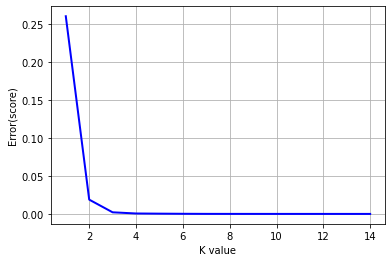

In [20]:
#To plot the k values and its score
plt.plot(range(1,15),score,color = 'b' , linewidth='2')
plt.xlabel("K value")
plt.ylabel("Error(score)")
plt.grid()
plt.show()

In [71]:
#Labels for the best K value 3
kcluster=3
kmeans = KMeans(n_clusters=kcluster, random_state=0)
kmeans.fit(indrest_grouped_cluster)

kmeans.labels_

array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [72]:
#Assign the labels to the neighborhood
indrest_merged = df_indrest.copy()
indrest_merged['ClusterName']=kmeans.labels_
df_indrest['ClusterName']=kmeans.labels_

indrest_merged
df_indrest

Neighbourhood  Indian Restaurant  ClusterName
0       LAGUNITAS           0.500000            1
1          ALBANY           0.065217            2
2     SAN LORENZO           0.062500            2
3        BRISBANE           0.052632            2
4    WALNUT CREEK           0.050000            2
..            ...                ...          ...
82  HALF MOON BAY           0.000000            0
83      GREENBRAE           0.000000            0
84        FREMONT           0.000000            0
85  FOREST KNOLLS           0.000000            0
86       WOODACRE           0.000000            0

[87 rows x 3 columns]

In [73]:
#Joining the neighborhood clusters with Venue data 
indrest_merged=indrest_merged.join(bayarea_venues.set_index('Neighbourhood'),on='Neighbourhood')

indrest_merged.head(15)

Neighbourhood  Indian Restaurant  ClusterName  Neighbourhood Latitude  \
0     LAGUNITAS           0.500000            1                 38.0139   
0     LAGUNITAS           0.500000            1                 38.0139   
0     LAGUNITAS           0.500000            1                 38.0139   
0     LAGUNITAS           0.500000            1                 38.0139   
1        ALBANY           0.065217            2                 37.8900   
1        ALBANY           0.065217            2                 37.8900   
1        ALBANY           0.065217            2                 37.8900   
1        ALBANY           0.065217            2                 37.8900   
1        ALBANY           0.065217            2                 37.8900   
1        ALBANY           0.065217            2                 37.8900   
1        ALBANY           0.065217            2                 37.8900   
1        ALBANY           0.065217            2                 37.8900   
1        ALBANY           0.065217            2                 37.8900   
1        ALBANY           0.065217            2                 37.8900   
1        ALBANY           0.065217            2                 37.8900   

   Neighbourhood Longitude                      Venue  Venue Latitude  \
0                -122.7016                  Arti Cafe       38.012457   
0                -122.7016          Lagunitas Grocery       38.012353   
0                -122.7016     The Phoenix Collection       38.012379   
0                -122.7016           Arti Indian Cafe       38.012840   
1                -122.2954               Hal's Office       37.890522   
1                -122.2954          Little Star Pizza       37.890453   
1                -122.2954            Sam's Log Cabin       37.888589   
1                -122.2954    Kim's Café & Sandwiches       37.890721   
1                -122.2954  As You Wish Frozen Yogurt       37.890518   
1                -122.2954   Highwire Coffee Roasters       37.890580   
1                -122.2954        Oori Rice Triangles       37.890653   
1                -122.2954                   La Crema       37.890233   
1                -122.2954                    Zaytoon       37.890500   
1                -122.2954                   Hot Shop       37.890021   
1                -122.2954  Albany Twin Movie Theater       37.890590   

   Venue Longitude            Venue Category  
0      -122.701456         Indian Restaurant  
0      -122.701677             Grocery Store  
0      -122.701523                  Tea Room  
0      -122.701698         Indian Restaurant  
1      -122.295885                      Café  
1      -122.296817               Pizza Place  
1      -122.298258            Breakfast Spot  
1      -122.292261                      Café  
1      -122.295977        Frozen Yogurt Shop  
1      -122.291395               Coffee Shop  
1      -122.293879          Asian Restaurant  
1      -122.298557        Mexican Restaurant  
1      -122.297764  Mediterranean Restaurant  
1      -122.298553             Burrito Place  
1      -122.298277       Indie Movie Theater

In [74]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=8)

# set color scheme for the clusters
x = np.arange(kcluster)
ys = [i + x + (i*x)**2 for i in range(kcluster)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(indrest_merged['Neighbourhood Latitude'], indrest_merged['Neighbourhood Longitude'], indrest_merged['Neighbourhood'], indrest_merged['ClusterName']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Final Counts to Conclude

In [75]:
 indrest_merged['Venue Category'].value_counts()['Indian Restaurant']


40

In [76]:
df_counts= pd.DataFrame(columns=['CountofNeighborhood','CountofIndianRest','AvgIndianRest'])
df_counts['CountofNeighborhood'] = df_indrest['ClusterName'].value_counts()

In [77]:
df_cluster0 = indrest_merged.loc[indrest_merged['ClusterName'] == 0].reset_index(drop=True)
df_counts.loc[0,'CountofIndianRest'] = df_cluster0['Venue Category'].value_counts()['Indian Restaurant']

In [78]:
df_cluster1=indrest_merged.loc[indrest_merged['ClusterName'] == 1].reset_index(drop=True)
df_counts.loc[1,'CountofIndianRest'] = df_cluster1['Venue Category'].value_counts()['Indian Restaurant']

In [79]:
df_cluster2 = indrest_merged.loc[indrest_merged['ClusterName'] == 2].reset_index(drop=True)
df_counts.loc[2,'CountofIndianRest'] = df_cluster2['Venue Category'].value_counts()['Indian Restaurant']

In [80]:
df_counts['AvgIndianRest']=df_counts['CountofIndianRest']/df_counts['CountofNeighborhood']
df_counts

CountofNeighborhood CountofIndianRest AvgIndianRest
0                   76                15      0.197368
2                   10                23           2.3
1                    1                 2             2